In [3]:
from tqdm.auto import tqdm
import nibabel as nib
import torch
from utils.visualization import plot_reverse_diffusion
import matplotlib.pyplot as plt
torch.cuda.empty_cache()

In [4]:
test = nib.load('../DB_IA-Gen-Med-Im/198001254/92/198001254_IRMpre_Court_207.0_92_.nii')
test.header

## Chargement du dataset des IRMs

In [5]:
from data.MRI_Dataset import MRI_Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, RandomHorizontalFlip, ToTensor, ConvertImageDtype

transform = Compose([
    #RandomHorizontalFlip(),
    ToTensor(),
    ConvertImageDtype(torch.float32),
    #transforms.Lambda(lambda t: (t * 2) - 1)
])

dataset = MRI_Dataset(
    dataset_path='../DB_IA-Gen-Med-Im', 
    manifest_filename='MRI_dataset_manifest.csv', 
    transform=transform
)

print(f'dataset size: {len(dataset)} samples')

channels, image_size, _ = dataset[0][0].shape
batch_size = 1

# create dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

dataset size: 2740 samples


For each sample, our dataset always return a tupple of our 3 images.<br>
Always by following the order, preMRI, treatment, postMRI

## Visionnage du dataset

### pre-MRI

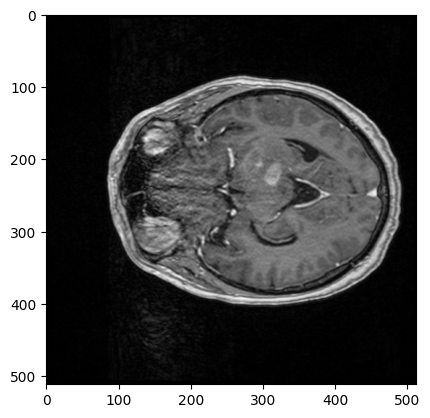

In [6]:
plt.imshow(dataset[0][0].reshape(image_size, image_size, channels), cmap='gray')

### RT-struct

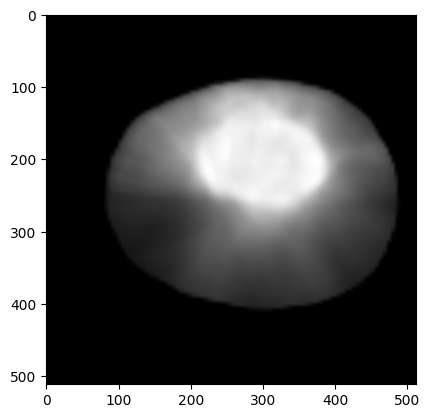

In [7]:
plt.imshow(dataset[0][1].reshape(image_size, image_size, channels), cmap='gray')

### post-MRI

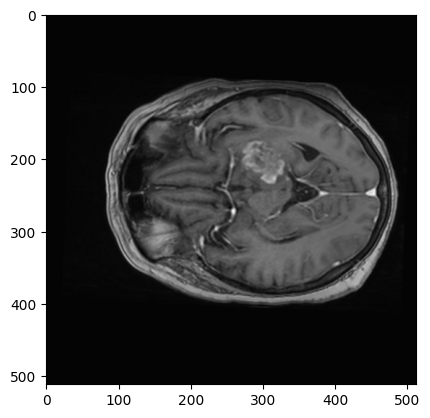

In [8]:
plt.imshow(dataset[0][2].reshape(image_size, image_size, channels), cmap='gray')

## Déclaration du modèle 

In [9]:
from torch.optim import Adam
from models.TemporalUNet import TemporalUNet
from models.DDPM import DDPM


device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

model = TemporalUNet(
    in_channels=1,
    out_channels=1,
    channel_scale=image_size,
    channels_mult=(1, 2, 4,)
)

optimizer = Adam(model.parameters(), lr=1e-3)

diffusion_model = DDPM(denoiser=model, timestep=300, schedule_type='cosine')

In [10]:
epochs = 6
losses = []

for epoch in range(epochs):
    training_batches_progress = tqdm(range(len(dataloader)),
                                 desc='Epoch {}/{}'.format(epoch + 1, epochs))
    losses.append(0.0)
    
    for images_batch in dataloader:
        preMRI_batch, treatment_batch, postMRI_batch = images_batch
        preMRI_batch = preMRI_batch.to(device)
    
        optimizer.zero_grad()
        loss = diffusion_model.compute_loss(preMRI_batch)
        loss.backward()
        optimizer.step()
    
        losses[-1] += len(preMRI_batch) * loss.item()
        
        training_batches_progress.update()
    losses[-1] /= len(dataset)
    
    training_batches_progress.set_postfix_str(str(f'Loss: {losses[-1]:.4f}'))
    training_batches_progress.close()

Epoch 1/6:   0%|          | 0/2740 [00:00<?, ?it/s]

KeyboardInterrupt: 